In [12]:
import optuna
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras.optimizers import Adam, SGD
from optuna.samplers import TPESampler, GridSampler


In [13]:
#test.csv,train.csvを取得
X_train_path = "/Users/NishimuraYuto/Desktop/ML/ML_git/MLT/ML_9/X_train.csv"
y_train_path = "/Users/NishimuraYuto/Desktop/ML/ML_git/MLT/ML_9/y_train.csv"
X_test_path = "/Users/NishimuraYuto/Desktop/ML/ML_git/MLT/ML_9/X_test.csv"
y_test_path = "/Users/NishimuraYuto/Desktop/ML/ML_git/MLT/ML_9/y_test.csv"
df_train_path = "/Users/NishimuraYuto/Desktop/ML/ML_git/MLT/ML_9/df_train.csv"
df_test_path = "/Users/NishimuraYuto/Desktop/ML/ML_git/MLT/ML_9/df_test.csv"

# Numpy配列としてよみこむ
X_train = pd.read_csv(X_train_path)
y_train = pd.read_csv(y_train_path)
X_test = pd.read_csv(X_test_path)
y_test = pd.read_csv(y_test_path)

# dfはDataFrameとしてよみこむ
df_train = pd.read_csv(df_train_path)
df_test = pd.read_csv(df_test_path)



In [18]:
rmses = []
folds = 10
print(X_train.shape)

def create_model(trial):
    inputs = Input(shape=(25,))

    # 入力層を作成
    x = Dense(25, activation='relu')(inputs)

    # 中間層の作成
    # ハイパーパラメータの最適化
    n_layers = trial.suggest_int('n_layers', 1, 5)
    units = trial.suggest_int('n_units', 8, 256, step=8)
    for i in range(n_layers):
        x = Dense(units=units, activation='relu')(x)
        
    x = Flatten()(x)

    # 出力層の作成
    predictions = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=predictions)

    # オプティマイザと学習率の最適化
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'RMSProp'])
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)

    if optimizer_name == 'adam':
        optimizer = Adam()
    if optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=lr)
    else:
        optimizer = 'RMSProp'

    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

def objective(trial):
    # モデルの作成
    model = create_model(trial)

    # batch_size範囲を指定
    batch_size = trial.suggest_int('batch_size', 16, 256, step=16)

    # KFold のオブジェクトを作成
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)

    
    for train_index, valid_index in kf.split(X_train):
        X_train_subset = X_train.loc[train_index].values
        y_train_subset = y_train.loc[train_index].values
        X_valid_subset = X_train.loc[valid_index].values
        y_valid_subset = y_train.loc[valid_index].values

        # トレーニング
        model.fit(
            X_train_subset, y_train_subset, 
            batch_size=batch_size,
            epochs=100, 
            verbose=0
        )

        # 予測
        y_pred = model.predict(X_valid_subset)

        # NaN が含まれているか確認
        if np.isnan(y_pred).any():
            print(" NaN が含まれているので関数から抜け出します。")
            return 

        # RMSEを算出
        temp_rmse_valid = np.sqrt(mean_squared_error(y_valid_subset, y_pred))

        # RMSEをリストにappend
        rmses.append(temp_rmse_valid)

        # CVのRMSEの平均値を目的関数として返す
        return np.mean(rmses)
    

# ------------------------------------
# # ベイズ最適化
sampler = TPESampler()
study = optuna.create_study(sampler=sampler, direction='minimize')
study.optimize(objective, n_trials=10)

print('Number of finalized trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

# 最適なパラメータの表示

for key, value in study.best_trial.params.items():
    print(f'    {key}: {value}')

[I 2023-12-13 11:58:59,958] A new study created in memory with name: no-name-28ba1b42-cb15-40b5-97cc-626b66e31107


(403, 25)


/var/folders/x2/7ynqzg2x3v70_clycbsk9h800000gn/T/ipykernel_37983/2814930370.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[W 2023-12-13 11:59:04,558] Trial 0 failed with parameters: {'n_layers': 4, 'n_units': 160, 'optimizer': 'sgd', 'lr': 0.0003237095365829379, 'batch_size': 16} because of the following error: The value None could not be cast to float..
[W 2023-12-13 11:59:04,558] Trial 0 failed with value None.


 NaN が含まれているので関数から抜け出します。


/var/folders/x2/7ynqzg2x3v70_clycbsk9h800000gn/T/ipykernel_37983/2814930370.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2023-12-13 11:59:08,336] Trial 1 finished with value: 18.0500203512873 and parameters: {'n_layers': 4, 'n_units': 248, 'optimizer': 'adam', 'lr': 0.00021565078019410502, 'batch_size': 128}. Best is trial 1 with value: 18.0500203512873.
/var/folders/x2/7ynqzg2x3v70_clycbsk9h800000gn/T/ipykernel_37983/2814930370.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2023-12-13 11:59:11,637] Trial 2 finished with value: 19.571936389722293 and parameters: {'n_layers': 3, 'n_units': 184, 'optimizer': 'RMSProp', 'lr': 0.0005814831644082057, 'batch_size': 224}. Best is trial 1 with value: 18.0500203512873.
/var/folders/x2/7ynqzg2x3v70_clycbsk9h800000gn/T/ipykernel_37983/2814930370.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


[I 2023-12-13 11:59:14,207] Trial 3 finished with value: 20.368994711200614 and parameters: {'n_layers': 1, 'n_units': 248, 'optimizer': 'sgd', 'lr': 0.0005619092412786589, 'batch_size': 160}. Best is trial 1 with value: 18.0500203512873.
/var/folders/x2/7ynqzg2x3v70_clycbsk9h800000gn/T/ipykernel_37983/2814930370.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2023-12-13 11:59:17,349] Trial 4 finished with value: 21.14496255014817 and parameters: {'n_layers': 5, 'n_units': 232, 'optimizer': 'sgd', 'lr': 1.7310753309058926e-05, 'batch_size': 176}. Best is trial 1 with value: 18.0500203512873.
/var/folders/x2/7ynqzg2x3v70_clycbsk9h800000gn/T/ipykernel_37983/2814930370.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


[I 2023-12-13 11:59:20,232] Trial 5 finished with value: 21.036926303058166 and parameters: {'n_layers': 1, 'n_units': 176, 'optimizer': 'adam', 'lr': 2.855530400362039e-05, 'batch_size': 160}. Best is trial 1 with value: 18.0500203512873.
/var/folders/x2/7ynqzg2x3v70_clycbsk9h800000gn/T/ipykernel_37983/2814930370.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2023-12-13 11:59:23,350] Trial 6 finished with value: 20.711624181232352 and parameters: {'n_layers': 3, 'n_units': 48, 'optimizer': 'adam', 'lr': 0.0007029281444819162, 'batch_size': 256}. Best is trial 1 with value: 18.0500203512873.
/var/folders/x2/7ynqzg2x3v70_clycbsk9h800000gn/T/ipykernel_37983/2814930370.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


[I 2023-12-13 11:59:25,788] Trial 7 finished with value: 21.0064478842604 and parameters: {'n_layers': 1, 'n_units': 32, 'optimizer': 'sgd', 'lr': 0.0004013011460267824, 'batch_size': 240}. Best is trial 1 with value: 18.0500203512873.
/var/folders/x2/7ynqzg2x3v70_clycbsk9h800000gn/T/ipykernel_37983/2814930370.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2023-12-13 11:59:29,294] Trial 8 finished with value: 20.371713888475774 and parameters: {'n_layers': 4, 'n_units': 104, 'optimizer': 'RMSProp', 'lr': 9.406856154620969e-05, 'batch_size': 112}. Best is trial 1 with value: 18.0500203512873.
/var/folders/x2/7ynqzg2x3v70_clycbsk9h800000gn/T/ipykernel_37983/2814930370.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


[I 2023-12-13 11:59:32,790] Trial 9 finished with value: 19.849831104472173 and parameters: {'n_layers': 1, 'n_units': 168, 'optimizer': 'adam', 'lr': 0.00435202226086347, 'batch_size': 32}. Best is trial 1 with value: 18.0500203512873.


Number of finalized trials: 10
Best trial: {'n_layers': 4, 'n_units': 248, 'optimizer': 'adam', 'lr': 0.00021565078019410502, 'batch_size': 128}
    n_layers: 4
    n_units: 248
    optimizer: adam
    lr: 0.00021565078019410502
    batch_size: 128


128


/var/folders/x2/7ynqzg2x3v70_clycbsk9h800000gn/T/ipykernel_37983/2814930370.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


dict_keys(['loss'])
{'loss': [28008.8828125, 14084.78515625, 3527.561767578125, 2190.23193359375, 1230.4208984375, 873.376220703125, 1183.6680908203125, 920.2081298828125, 1041.3388671875, 549.4146118164062, 462.5320129394531, 1117.1083984375, 478.73388671875, 488.61444091796875, 779.751953125, 479.3966979980469, 761.7714233398438, 515.8392333984375, 447.7171936035156, 632.1338500976562, 523.0765991210938, 462.3673095703125, 537.5068359375, 721.1339111328125, 503.2080993652344, 447.7406005859375, 591.7373046875, 658.1446533203125, 274.9266662597656, 289.67852783203125, 740.1311645507812, 333.1524658203125, 315.3795471191406, 583.4091186523438, 656.78125, 314.04754638671875, 538.0859985351562, 300.2625732421875, 481.5166015625, 687.3258666992188, 338.8665771484375, 219.217529296875, 205.85491943359375, 632.8285522460938, 594.64794921875, 220.078369140625, 319.4790954589844, 638.2564086914062, 368.22344970703125, 357.1099853515625, 347.2151184082031, 495.16156005859375, 307.0096435546875

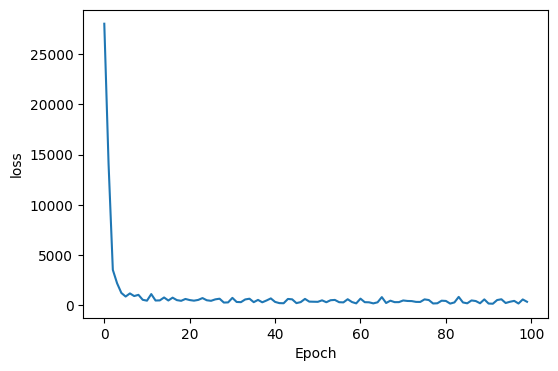

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Final MSE on test data: 1114.4182110314985
Finished ML_10_trial_op3.py


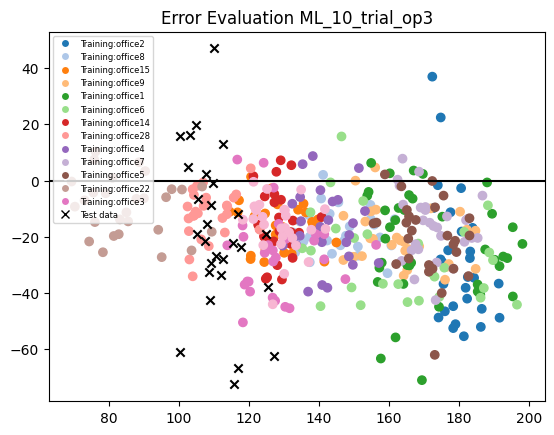

In [22]:
# X_train = X_train.values
# y_train = y_train.values
# X_test = X_test.values
# y_test = y_test.values

best_batch_size = study.best_trial.params['batch_size']
print(best_batch_size)
# 最適なパラメータを使ってモデルの作成
best_model = create_model(study.best_trial)
train_history = best_model.fit(
                                X_train, y_train, 
                                batch_size=best_batch_size,
                                epochs=100, 
                                verbose=0
                            )

print(train_history.history.keys())

print(train_history.history)
print(len(train_history.history['loss']))

# エポックごとの損失関数値をプロットしてみる
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(train_history.history['loss'])
ax.set_xlabel('Epoch')
ax.set_ylabel('loss')
plt.show()

# 評価
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
final_mse = mean_squared_error(y_test, y_test_pred)
print('Final MSE on test data:', final_mse)
# print(y_test_pred)


# 図を作成するための準備
df_train['predict values'] = y_train_pred
df_train['residuals'] = y_train_pred - y_train
df_test['predict values'] = y_test_pred
df_test['residuals'] = y_test_pred - y_test


#df_trainに'legend'列を追加(凡例)
root_directory = "/Users/NishimuraYuto/Desktop/ML/ML_git/MLT/ML_9/"
for folder_name in os.listdir(root_directory):  
        for index,row in df_train.iterrows() :           #１行ずつ実行
                if folder_name + '_' in row['case_name']:                 #case_nameにfolder_nameが含まれているかどうか
                        df_train.loc[index,'legend'] = 'Training:' + folder_name

df_test['legend'] = 'Test data'

df_forfig = pd.concat([df_train, df_test])
# df_forfig.to_csv("/home/gakubu/デスクトップ/ML_git/MLT/ML_9/ML_9_5/df_forfig XGB.csv"\
#                         ,encoding='utf_8_sig', index=False)

#-----Error Evaluation (+test) DTR.pdfの作成-------------------------------------------
# 各オフィス名に対する色を 'tab20' カラーマップから取得
legend_names = df_train['legend'].unique()      #unique()メソッドは指定した列内の一意の値の配列を返す（重複を取り除く）
# print(legend_names)
colors = plt.cm.tab20(range(len(legend_names))) #tab20から配列legemd_namesの長さ分の色の配列colorsを返す
# 凡例名と色の対応を辞書に格納
# zip関数は２つ以上のリストを取り、それらの対応する要素をペアにしてイテレータを返す。
# この場合、legend_namesとcolorsの２つのリストをペアにし、対応する要素同士を取得する。
# =以降はofficeをキーとしてそれに対応するcolorが"値"として格納される辞書を作成
legend_color_mapping = {legend: color for legend, color in zip(legend_names, colors)}
# print(legend_color_mapping)
# 'legend' 列を数値（色情報に対応する数値）に変換
# 'legend_num'　を追加
df_train['legend_num'] = df_train['legend'].map(legend_color_mapping)
#散布図を作成
plt.scatter(df_train['predict values'], df_train['residuals'], c=df_train['legend_num'])
plt.scatter(df_test['predict values'], df_test['residuals'], c='black', marker='x' )
#y=0の直線を引く
# y = 0 の直線を描く
plt.axhline(y=0, color='black', linestyle='-')

# 凡例を作成
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, \
                        markersize=6, label=legend) for legend, color in zip(legend_names, colors)]
# Test dataの凡例を追加
handles[-1] = plt.Line2D([0], [0] ,marker='x', color='black', markersize=6, label='Test data', linestyle='None')

# 凡例を表示
plt.legend(handles=handles, loc='upper left', fontsize=6)


plt.title('Error Evaluation ML_10_trial_op3')
plt.savefig("/Users/NishimuraYuto/Desktop/ML/ML_git/MLT/ML_10/Error Evaluation 10 trial op3.pdf", format='pdf') 
# plt.show()
#-----------------------------------------------------------------------------------

print('Finished ML_10_trial_op3.py')



#各種評価指標をcsvファイルとして出力する
df_ee = pd.DataFrame({'R^2(決定係数)': [r2_score(y_test, y_test_pred)],
                        'RMSE(二乗平均平方根誤差)': [np.sqrt(mean_squared_error(y_test, y_test_pred))],
                        'MSE(平均二乗誤差)': [mean_squared_error(y_test, y_test_pred)],
                        'MAE(平均絶対誤差)': [mean_absolute_error(y_test, y_test_pred)]})
df_ee.to_csv("/Users/NishimuraYuto/Desktop/ML/ML_git/MLT/ML_10/Error Evaluation 10 trial op3.csv",encoding='utf_8_sig', index=False)

df_ee_train = pd.DataFrame({'R^2(決定係数)': [r2_score(y_train, y_train_pred)],
                        'RMSE(二乗平均平方根誤差)': [np.sqrt(mean_squared_error(y_train, y_train_pred))],
                        'MSE(平均二乗誤差)': [mean_squared_error(y_train, y_train_pred)],
                        'MAE(平均絶対誤差)': [mean_absolute_error(y_train, y_train_pred)]})
df_ee_train.to_csv("/Users/NishimuraYuto/Desktop/ML/ML_git/MLT/ML_10/Error Evaluation 10 trial op3 train.csv",encoding='utf_8_sig', index=False)